In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, random_split
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.nn import SyncBatchNorm
from torchvision.models import resnet50
from torchvision.io import read_image
from torchvision.transforms import ToPILImage
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

target_shape = (200, 200)

In [2]:
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

left_dir_path = "ImgData/train/left"
right_dir_path = "ImgData/train/right"

left_images_path = getImagePaths(left_dir_path)
right_images_path = getImagePaths(right_dir_path)

print(f"Number of left images: {len(left_images_path)}\n")
print(f"Number of right images: {len(right_images_path)}\n")

Number of left images: 2000

Number of right images: 2000



In [3]:
def getShape(images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape=cv2.imread(image_path).shape
        if (image_shape!=shape):
            return "Different image shape"
        else:
            return "Same image shape " + str(shape)

In [4]:
left_images_path = sorted(left_images_path, key=lambda x: x.split('/')[-1])
right_images_path = sorted(right_images_path, key=lambda x: x.split('/')[-1])

In [5]:
anchor_images = left_images_path
positive_images = right_images_path

In [41]:
def preprocess_image(image_tensor):
    """
    Preprocess the input image tensor.
    """
    
    # Define the transformations: resize
    transform = transforms.Compose([
    transforms.Resize(target_shape, antialias=True),  # Explicitly set antialias to True
    ])
    
    # Apply the transformations
    print(image_tensor)
    image = transform(image_tensor)
    
    return image

def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )


def preprocess_doublets(anchor, test):
    return (
        preprocess_image(anchor),
        preprocess_image(test),
    )


In [7]:
left_images_path[0]

'ImgData/train/left\\aaa.jpg'

In [8]:
def find_co_path(path, lookup, target_path):
    file_name = os.path.basename(path)
    src_img_name=os.path.splitext(file_name)[0]
    co_img_name= lookup.loc[lookup['left']==src_img_name]['right']
    co_img_name=co_img_name.values[0]
    return os.path.join(target_path,co_img_name+'.jpg')
    
ilookup = pd.read_csv("train.csv")

In [9]:
find_co_path('ImgData/train/left/aaz.jpg', ilookup, right_dir_path)

'ImgData/train/right\\mqw.jpg'

In [10]:
class TLLDataset(Dataset):
    def __init__(self, anchor_image_paths, positive_image_paths, ilookup_path):
        # Load images and convert to tensors
        ilookup = pd.read_csv(ilookup_path)
        anchor_images = [read_image(path) for path in anchor_image_paths]
        positive_images = [read_image(find_co_path(path,ilookup,os.path.dirname(positive_image_paths[0]))) for path in anchor_image_paths]

        
        # Shuffle anchor and positive images to get negative images
        negative_images = anchor_images + positive_images
        random.shuffle(negative_images)
        
        self.anchor_images = torch.stack(anchor_images)
        self.positive_images = torch.stack(positive_images)
        self.negative_images = torch.stack(negative_images)
        
    def __len__(self):
        return len(self.anchor_images)
    
    def __getitem__(self, idx):
        anchor = self.anchor_images[idx]
        positive = self.positive_images[idx]
        negative = self.negative_images[idx]
        
        # Assuming preprocess_triplets is a function you have defined elsewhere
        anchor, positive, negative = preprocess_triplets(anchor, positive, negative)
        
        return anchor, positive, negative

ilookup_path = 'train.csv'
# Create an instance of TLLDataset
tll_dataset = TLLDataset(anchor_images,positive_images,ilookup_path)

# Determine the indices for training and validation
image_count = len(tll_dataset)
indices = list(range(image_count))
train_indices = indices[:round(image_count * 0.8)]
val_indices = indices[round(image_count * 0.8):]

# Create SubsetRandomSamplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoaders for training and validation
train_loader = DataLoader(tll_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(tll_dataset, batch_size=32, sampler=val_sampler)

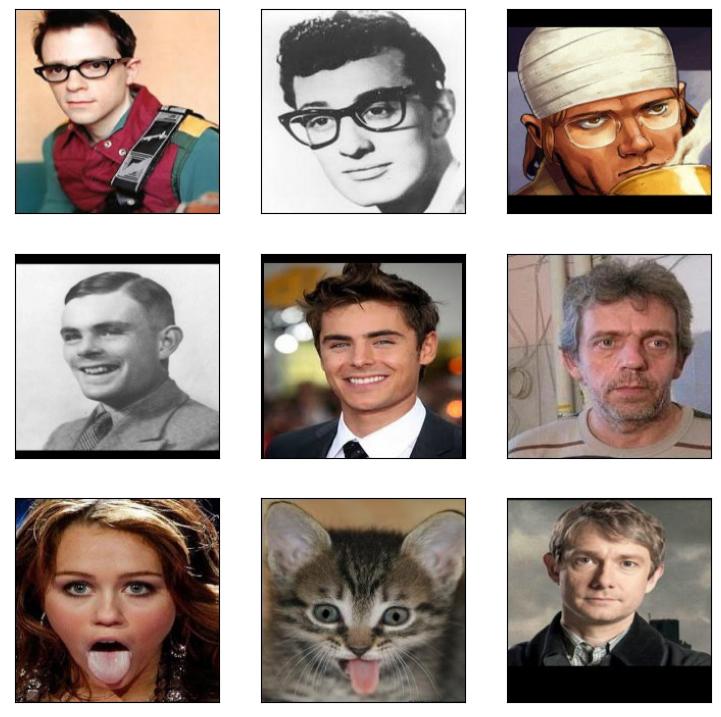

In [11]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""
    
    def show(ax, image_tensor):
        # Define a transform to convert a tensor to PIL image
        transform = transforms.ToPILImage()
        # Convert the tensor to PIL image using the above transform
        img = transform(image_tensor)
        
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig, axs = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

# Assuming train_loader is the PyTorch DataLoader for training data
# Get one batch of data
for anchor, positive, negative in train_loader:
    visualize(anchor, positive, negative)
    break  # visualize only one batch

In [12]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        # Load a pre-trained ResNet50 model
        resnet = resnet50()
        # Freeze all layers except the last Convolution block
        for name, param in resnet.named_parameters():
            if "layer4" not in name:
                param.requires_grad = False
        # Define the embedding network by adding a few dense layers
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Exclude the last FC layer
        self.flatten = nn.Flatten()
        self.dense1 = nn.Sequential(nn.Linear(2048, 512), nn.ReLU(), SyncBatchNorm(512))
        self.dense2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), SyncBatchNorm(256))
        self.output = nn.Linear(256, 256)
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.output(x)
        return x

embedding_net = EmbeddingNet()

In [88]:
class DistanceLayer(nn.Module):
    def __init__(self):
        super(DistanceLayer, self).__init__()

    def forward(self, anchor, positive, negative):
        ap_distance = F.pairwise_distance(anchor, positive, 2)
        an_distance = F.pairwise_distance(anchor, negative, 2)
        return ap_distance, an_distance

class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net
        self.distance_layer = DistanceLayer()
        
    def forward(self, anchor, positive, negative):
        anchor_embedding = self.embedding_net(anchor)
        positive_embedding = self.embedding_net(positive)
        negative_embedding = self.embedding_net(negative)
        ap_distance, an_distance = self.distance_layer(anchor_embedding, positive_embedding, negative_embedding)
        return ap_distance, an_distance

siamese_network = SiameseNetwork(embedding_net)

In [89]:
class TripletMarginLoss(nn.Module):
    def __init__(self, margin):
        super(TripletMarginLoss, self).__init__()
        self.margin = margin

    def forward(self, ap_distance, an_distance):
        return F.relu(ap_distance - an_distance + self.margin)

class SiameseModel:
    def __init__(self, siamese_network, device, margin=0.5, lr=1e-4):
        self.siamese_network = siamese_network
        self.criterion = TripletMarginLoss(margin)
        self.optimizer = torch.optim.Adam(self.siamese_network.parameters(), lr=lr)
        self.device = device
        self.loss_tracker = []
        self.test_loss_tracker = []
        
    def train_step(self, anchor, positive, negative):
        self.siamese_network.train()  # Set the model to training mode
        self.optimizer.zero_grad()
        ap_distance, an_distance = self.siamese_network(anchor, positive, negative)
        loss = self.criterion(ap_distance, an_distance)

        # Ensure the loss is a scalar
        if loss.numel() > 1:
            loss = loss.mean()  # or loss.sum(), depending on your use case

        loss.backward()
        self.optimizer.step()
        self.loss_tracker.append(loss.item())
        return loss.item()


    def test_step(self, anchor, positive, negative):
        self.siamese_network.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            ap_distance, an_distance = self.siamese_network(anchor, positive, negative)
            loss = self.criterion(ap_distance, an_distance)

            # Ensure the loss is a scalar
            if loss.numel() > 1:
                loss = loss.mean()  # or loss.sum(), depending on your use case

        self.test_loss_tracker.append(loss.item())
        return loss.item()


    def train_epoch(self, train_loader):
        epoch_loss = 0.0
        for anchor,positive,negative in train_loader:
            anchor = anchor.to(self.device, dtype=torch.float)
            positive = positive.to(self.device, dtype=torch.float)
            negative = negative.to(self.device, dtype=torch.float)
            
            loss = self.train_step(anchor, positive, negative)
            epoch_loss += loss
            
        torch.cuda.empty_cache()
        return epoch_loss / len(train_loader)

    def test_epoch(self, test_loader):
        epoch_loss = 0.0
        for anchor,positive,negative in test_loader:
            anchor = anchor.to(self.device, dtype=torch.float)
            positive = positive.to(self.device, dtype=torch.float)
            negative = negative.to(self.device, dtype=torch.float)
            
            loss = self.test_step(anchor, positive, negative)
            epoch_loss += loss
            
        torch.cuda.empty_cache()
        return epoch_loss / len(test_loader)

    def reset_states(self):
        self.loss_tracker = []
        self.test_loss_tracker = []

In [92]:
# Define the device and move the network to the device
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
siamese_network = siamese_network.to(device)

# Now, instantiate the SiameseModel with the siamese_network
siamese_model = SiameseModel(siamese_network, device, margin=0.5, lr=0.0001)

# Define the number of epochs
num_epochs = 10

# Start training
for epoch in range(num_epochs):
    train_loss = siamese_model.train_epoch(train_loader)
    val_loss = siamese_model.test_epoch(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    siamese_model.reset_states()   

Epoch 1/10, Train Loss: 0.4281, Validation Loss: 1.1888
Epoch 2/10, Train Loss: 0.4051, Validation Loss: 2.8952
Epoch 3/10, Train Loss: 0.3656, Validation Loss: 0.9547
Epoch 4/10, Train Loss: 0.3608, Validation Loss: 1.0492
Epoch 5/10, Train Loss: 0.2941, Validation Loss: 0.7583
Epoch 6/10, Train Loss: 0.2851, Validation Loss: 0.8529
Epoch 7/10, Train Loss: 0.2764, Validation Loss: 0.9114
Epoch 8/10, Train Loss: 0.2662, Validation Loss: 1.3451
Epoch 9/10, Train Loss: 0.2471, Validation Loss: 1.7519
Epoch 10/10, Train Loss: 0.2305, Validation Loss: 0.9634


In [97]:
torch.save(siamese_network.state_dict(), 'test.pt')

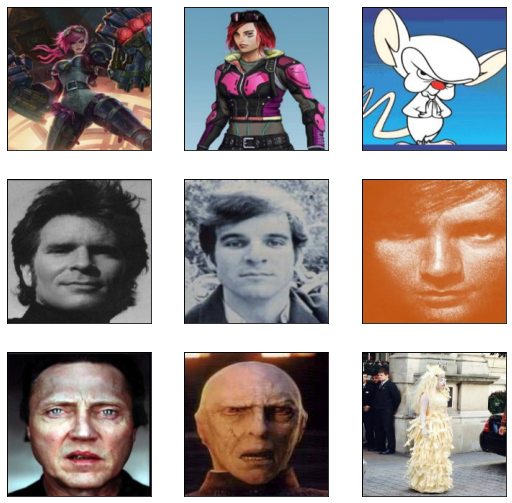

In [94]:
for anchor, positive, negative in train_loader:
    visualize(anchor, positive, negative)
    break  # visualize only one batch

# test codes

In [55]:
test_left_dir_path = "ImgData/test/left"
test_right_dir_path = "ImgData/test/right"

test_left_images_path = getImagePaths(test_left_dir_path)
test_right_images_path = getImagePaths(test_right_dir_path)



In [107]:
def find_co_paths(path, lookup, target_path):
    file_name = os.path.basename(path)
    src_img_name=os.path.splitext(file_name)[0]
    co_img_names= lookup.loc[lookup['left']==src_img_name].drop('left',axis = 1)  

    output_paths = []  
    for name in co_img_names.values[0]:
        output_paths.append(os.path.join(target_path,name+'.jpg'))
        
    return output_paths

In [83]:
test_lookup = pd.read_csv('test_candidates.csv')

In [108]:
find_co_paths('ImgData/test/left/abm.jpg', test_lookup, test_right_dir_path)

['ImgData/test/right\\kyr.jpg',
 'ImgData/test/right\\qqo.jpg',
 'ImgData/test/right\\xpv.jpg',
 'ImgData/test/right\\tnd.jpg',
 'ImgData/test/right\\xal.jpg',
 'ImgData/test/right\\pvr.jpg',
 'ImgData/test/right\\nsb.jpg',
 'ImgData/test/right\\yzv.jpg',
 'ImgData/test/right\\ahb.jpg',
 'ImgData/test/right\\mlm.jpg',
 'ImgData/test/right\\drb.jpg',
 'ImgData/test/right\\vqu.jpg',
 'ImgData/test/right\\vzr.jpg',
 'ImgData/test/right\\kxe.jpg',
 'ImgData/test/right\\mdq.jpg',
 'ImgData/test/right\\oai.jpg',
 'ImgData/test/right\\nmm.jpg',
 'ImgData/test/right\\yzu.jpg',
 'ImgData/test/right\\ihk.jpg',
 'ImgData/test/right\\zwv.jpg']

In [136]:
## classifier
class PairwiseDistanceLayer(nn.Module):
    def __init__(self):
        super(DistanceLayer, self).__init__()

    def forward(self, anchor, test):
        distances = F.pairwise_distance(anchor, test, 2)
        return distances


class outputlayer(nn.Module):
    def __init__(self, embedding_net):
        super(outputlayer, self).__init__()
        self.embedding_net = embedding_net
        self.distance_layer = PairwiseDistanceLayer()
        
    def forward(self, anchor, tests):
        anchor_embedding = torch.unsqueeze(self.embedding_net(anchor),0)
        test_embedding = self.embedding_net(tests)
        distances = torch.flatten((self.distance_layer(anchor_embedding, test_embedding)))
        output = nn.Softmax(dim=1)(distances)
        return output


class testDataset(Dataset):
    def __init__(self,test_anchor_image_paths, test_image_paths, test_candidates):
        self.test_candidates_df = pd.read_csv(test_candidates)

        test_anchor_images = [read_image(path) for path in test_anchor_image_paths]

        test_images_paths = [find_co_paths(path,self.test_candidates_df,os.path.dirname(test_image_paths[0])) for path in test_anchor_image_paths]
    
        test_images = [read_image(p) for paths in test_images_paths for p in paths]

        


        self.test_anchor_images = torch.stack(test_anchor_images)
        self.test_images = torch.stack(test_images)

        print(self.test_anchor_images.shape)
        print(self.test_images.shape)
        

    def __len__(self):
        return len(self.test_candidates_df.index)
    def __getitem__(self, idx):

        anchor = self.test_anchor_images[idx]
        test = self.test_images[idx: idx + 20]

        anchor, test = preprocess_doublets(anchor, test)

        print(anchor.shape)
        print(test.shape)
        return anchor, test



In [137]:
testset = testDataset(test_left_images_path, test_right_images_path,"test_candidates.csv")

torch.Size([2000, 3, 245, 200])
torch.Size([40000, 3, 245, 200])


In [138]:
test_loader = DataLoader(testset, batch_size=32)



In [140]:
testNet = outputlayer(embedding_net)

criterion = optim.Adam()

with torch.no_grad:
    for anchor, tests in test_loader:
        t1, t2 = testNet(anchor, tests)
        print(t1)
        print(t2)
        break


NameError: name 'DistanceLayer' is not defined